In [14]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import sqlite3
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Get project root (parent of this notebook's folder)
project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(project_root)


In [2]:
from src.clv import (
    calculate_rfm,
    calculate_rfm_scores,
    segment_customers_rfm,
    get_segment_summary,
    calculate_historic_clv,
    prepare_clv_data,
    calculate_simple_predictive_clv,
    calculate_clv_segments,
    plot_rfm_distribution,
    plot_rfm_segments,
    plot_rfm_heatmap,
    plot_clv_distribution
)
from src.analysis_utils import print_business_summary

✅ E-commerce Analytics Package v1.0.0 loaded successfully


In [3]:
# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Connect to database
DB_PATH = '../db/retail.db'
conn = sqlite3.connect(DB_PATH)

print("✅ Libraries and functions loaded successfully")

✅ Libraries and functions loaded successfully


## 1. LOAD AND PREPARE DATA

In [4]:
# Load transactions
df = pd.read_sql("SELECT * FROM transactions", conn)
df['invoice_date'] = pd.to_datetime(df['invoice_date'])

print(f"Dataset: {len(df):,} transactions")
print(f"Customers: {df['customer_id'].nunique():,}")
print(f"Date Range: {df['invoice_date'].min().date()} to {df['invoice_date'].max().date()}")

# Quick business summary
print("\n" + "="*80)
print_business_summary(df)

Dataset: 762,556 transactions
Customers: 5,720
Date Range: 2009-12-01 to 2011-12-09

📊 BUSINESS SUMMARY

📅 Time Period:
   From: 2009-12-01
   To: 2011-12-09
   Duration: 738 days

💰 Revenue Metrics:
   Total Revenue: $10,008,863.47
   Avg Transaction Value: $13.13
   Median Transaction Value: $10.50

👥 Customer Metrics:
   Total Customers: 5,720
   Avg Revenue per Customer: $1,749.80
   Avg Orders per Customer: 5.96

📦 Order Metrics:
   Total Orders: 34,111
   Total Items Sold: 6,303,316
   Unique Products: 4,604

🌍 Geographic Coverage:
   Countries Served: 41
   Top Country: United Kingdom



## 2. CALCULATE RFM METRICS

In [5]:
print("\n" + "="*80)
print("📊 CALCULATING RFM METRICS")
print("="*80)

# Calculate RFM
rfm = calculate_rfm(df)

print(f"\nRFM calculated for {len(rfm):,} customers")
print("\nRFM Summary Statistics:")
print(rfm[['recency', 'frequency', 'monetary']].describe())

# Show sample
print("\nSample RFM Data (Top 10 by Monetary):")
print(rfm.nlargest(10, 'monetary')[['customer_id', 'recency', 'frequency', 'monetary']])



📊 CALCULATING RFM METRICS

RFM calculated for 5,720 customers

RFM Summary Statistics:
           recency    frequency       monetary
count  5720.000000  5720.000000    5720.000000
mean    201.089510     5.963462    1749.801306
std     209.051651    11.848562    4349.477536
min       1.000000     1.000000       1.900000
25%      26.000000     1.000000     300.037500
50%      95.000000     3.000000     728.380000
75%     380.000000     7.000000    1810.112500
max     739.000000   374.000000  213997.570000

Sample RFM Data (Top 10 by Monetary):
      customer_id  recency  frequency   monetary
2466        14911        1        374  213997.57
719         13089        4        175   69346.23
1876        14298        8         75   66420.89
5289        17841        2        210   62332.13
1737        14156       10        126   59084.82
5297        17850      372        155   53847.98
1680        14096        4         17   46531.74
711         13081       12         26   43067.95
390      

## 3. VISUALIZE RFM DISTRIBUTIONS


📈 RFM DISTRIBUTIONS


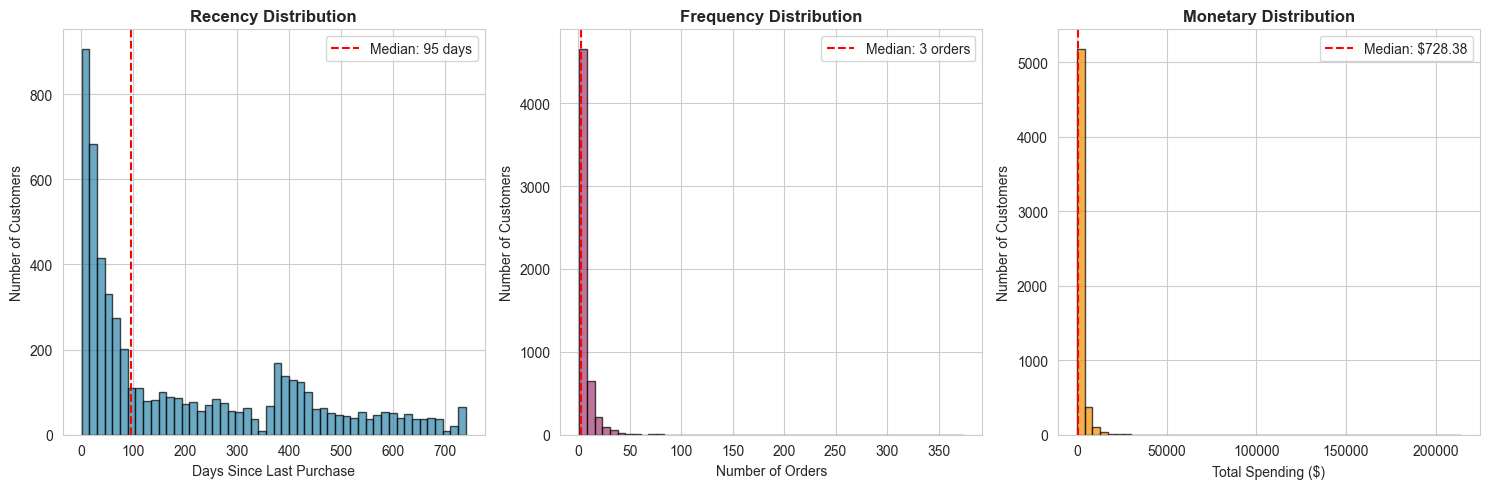


💡 Key Observations:
• Median Recency: 95 days
• Median Frequency: 3 orders
• Median Monetary: $728.38
• Average Monetary: $1,749.80
• RFM distributions are right-skewed, indicating a small number of highly engaged customers.


In [6]:
print("\n" + "="*80)
print("📈 RFM DISTRIBUTIONS")
print("="*80)

plot_rfm_distribution(rfm)

print("\n💡 Key Observations:")
print(f"• Median Recency: {rfm['recency'].median():.0f} days")
print(f"• Median Frequency: {rfm['frequency'].median():.0f} orders")
print(f"• Median Monetary: ${rfm['monetary'].median():,.2f}")
print(f"• Average Monetary: ${rfm['monetary'].mean():,.2f}")
print("• RFM distributions are right-skewed, indicating a small number of highly engaged customers.")

## 4. CALCULATE RFM SCORES

In [7]:
print("\n" + "="*80)
print("🎯 CALCULATING RFM SCORES")
print("="*80)

# Calculate RFM scores (1-5 scale)
rfm_scored = calculate_rfm_scores(rfm, quantiles=5)

print("\nRFM Scores calculated!")
print("\nSample Scored Data:")
print(rfm_scored.head(10))

# Score distribution
print("\n📊 Score Distributions:")
for score in ['r_score', 'f_score', 'm_score']:
    print(f"\n{score.upper()} Distribution:")
    print(rfm_scored[score].value_counts().sort_index())



🎯 CALCULATING RFM SCORES

RFM Scores calculated!

Sample Scored Data:
   customer_id  recency  frequency  monetary  r_score  f_score  m_score  \
0        12346      529         11    372.86        1        5        2   
1        12347        2          8   4769.50        5        4        5   
2        12348       75          5   1025.40        3        4        4   
3        12349       19          3   3143.39        5        3        5   
4        12350      310          1    334.40        2        1        2   
5        12351      375          1    300.93        2        1        2   
6        12352       36          9   1849.54        4        5        4   
7        12353      204          2    406.76        2        2        2   
8        12354      232          1   1079.40        2        1        4   
9        12355      214          2    752.61        2        2        3   

  rfm_score  total_score  
0       152            8  
1       545           14  
2       344           

## 5. CUSTOMER SEGMENTATION

In [8]:

print("\n" + "="*80)
print("👥 CUSTOMER SEGMENTATION")
print("="*80)

# Segment customers based on RFM scores
rfm_segmented = segment_customers_rfm(rfm_scored)

print(f"\nCustomers segmented into {rfm_segmented['segment'].nunique()} segments")

# Segment distribution
segment_counts = rfm_segmented['segment'].value_counts()
print("\n📊 Segment Distribution:")
print(segment_counts)

# Get segment summary
segment_summary = get_segment_summary(rfm_segmented)
print("\n💰 Segment Summary:")
print(segment_summary.to_string(index=False))


👥 CUSTOMER SEGMENTATION

Customers segmented into 9 segments

📊 Segment Distribution:
segment
Need Attention         1433
Champions              1265
Potential Loyalists     685
Loyal Customers         675
About to Sleep          636
Hibernating             447
Promising               369
Recent Customers        167
Lost                     43
Name: count, dtype: int64

💰 Segment Summary:
            segment  num_customers  avg_recency  avg_frequency  avg_monetary  total_revenue  customer_pct  revenue_pct
          Champions           1265    20.251383      15.854545   4952.957300    6265490.985     22.115385    62.599425
    Loyal Customers            675    82.982222       7.480000   1879.233609    1268482.686     11.800699    12.673594
     Need Attention           1433   273.184229       2.757851    753.348103    1079547.832     25.052448    10.785918
Potential Loyalists            685    25.665693       2.531387    740.526088     507260.370     11.975524     5.068112
     About t

## 6. VISUALIZE CUSTOMER SEGMENTS


📊 VISUALIZING CUSTOMER SEGMENTS


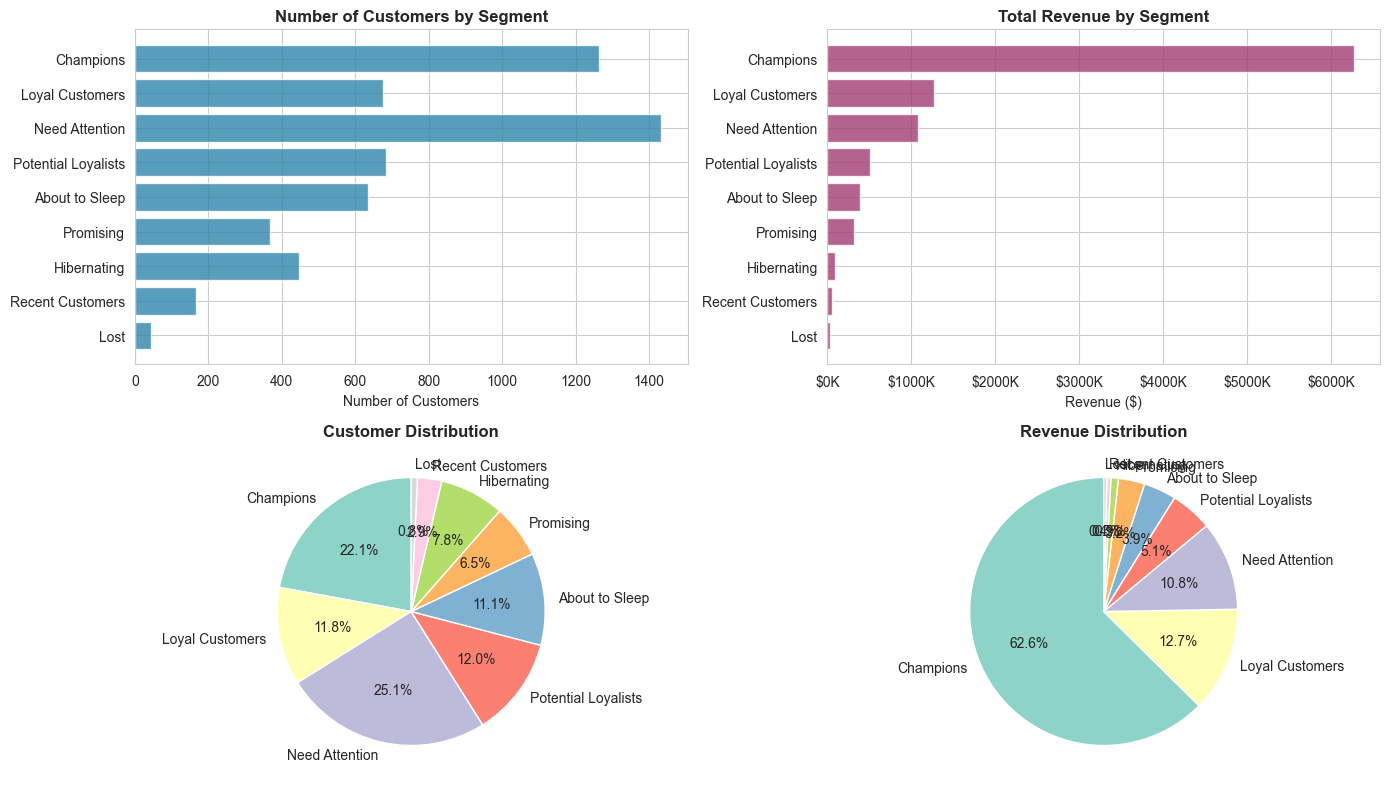

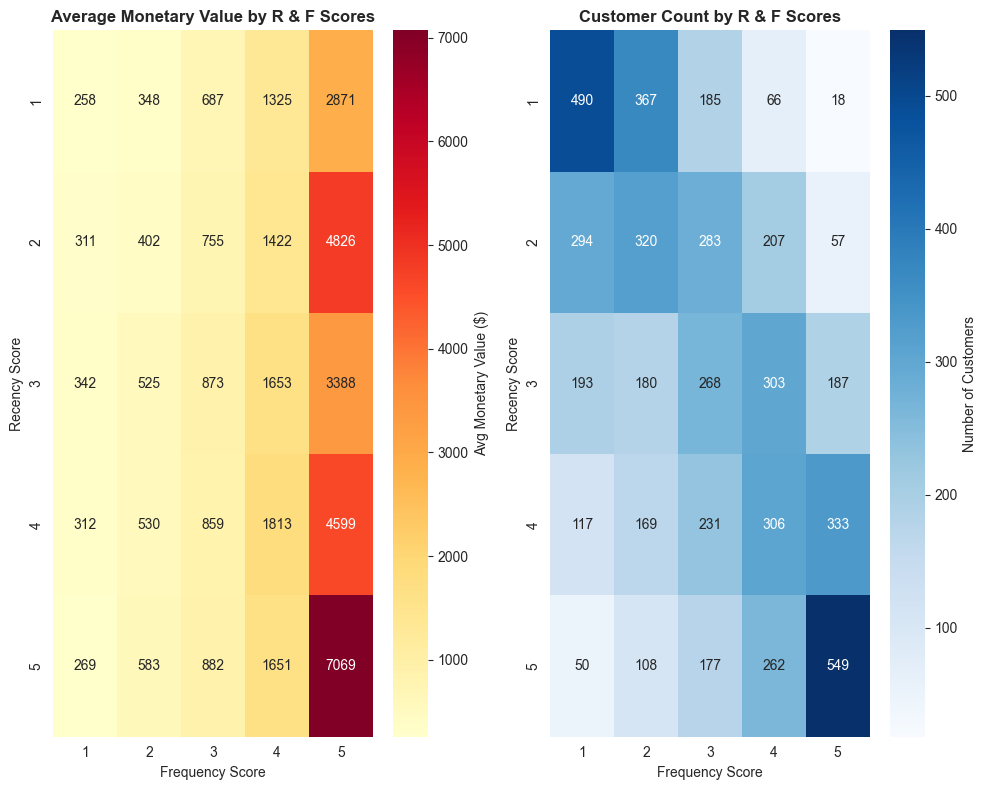

In [9]:
print("\n" + "="*80)
print("📊 VISUALIZING CUSTOMER SEGMENTS")
print("="*80)

# Plot segments
plot_rfm_segments(rfm_segmented)

# RFM Heatmap
plot_rfm_heatmap(rfm_scored)

## 7. SEGMENT ANALYSIS & INSIGHTS

In [10]:
print("\n" + "="*80)
print("🔍 SEGMENT INSIGHTS")
print("="*80)

# Top segments by revenue
top_segments = segment_summary.nlargest(5, 'total_revenue')
print("\n🏆 Top 5 Segments by Revenue:")
for idx, row in top_segments.iterrows():
    print(f"\n{row['segment']}:")
    print(f"  • Customers: {row['num_customers']:,} ({row['customer_pct']:.1f}%)")
    print(f"  • Revenue: ${row['total_revenue']:,.2f} ({row['revenue_pct']:.1f}%)")
    print(f"  • Avg Monetary: ${row['avg_monetary']:,.2f}")
    print(f"  • Avg Recency: {row['avg_recency']:.0f} days")
    print(f"  • Avg Frequency: {row['avg_frequency']:.1f} orders")

# Business insights
print("\n\n" + "="*80)
print("💡 KEY BUSINESS INSIGHTS")
print("="*80)

champions = segment_summary[segment_summary['segment'] == 'Champions']
if len(champions) > 0:
    print(f"\n🏆 Champions Segment:")
    print(f"   • {champions.iloc[0]['num_customers']} customers ({champions.iloc[0]['customer_pct']:.1f}%)")
    print(f"   • Generate ${champions.iloc[0]['total_revenue']:,.2f} ({champions.iloc[0]['revenue_pct']:.1f}% of revenue)")
    print(f"   • Strategy: Reward, upsell premium products, ask for reviews")

at_risk = segment_summary[segment_summary['segment'] == 'At Risk']
if len(at_risk) > 0:
    print(f"\n⚠️  At Risk Segment:")
    print(f"   • {at_risk.iloc[0]['num_customers']} customers ({at_risk.iloc[0]['customer_pct']:.1f}%)")
    print(f"   • Represent ${at_risk.iloc[0]['total_revenue']:,.2f} ({at_risk.iloc[0]['revenue_pct']:.1f}% of revenue)")
    print(f"   • Strategy: Win-back campaigns, special offers, personalized outreach")

lost = segment_summary[segment_summary['segment'] == 'Lost']
if len(lost) > 0:
    print(f"\n❌ Lost Segment:")
    print(f"   • {lost.iloc[0]['num_customers']} customers ({lost.iloc[0]['customer_pct']:.1f}%)")
    print(f"   • Strategy: Re-engagement campaigns, surveys to understand why")



🔍 SEGMENT INSIGHTS

🏆 Top 5 Segments by Revenue:

Champions:
  • Customers: 1,265 (22.1%)
  • Revenue: $6,265,490.99 (62.6%)
  • Avg Monetary: $4,952.96
  • Avg Recency: 20 days
  • Avg Frequency: 15.9 orders

Loyal Customers:
  • Customers: 675 (11.8%)
  • Revenue: $1,268,482.69 (12.7%)
  • Avg Monetary: $1,879.23
  • Avg Recency: 83 days
  • Avg Frequency: 7.5 orders

Need Attention:
  • Customers: 1,433 (25.1%)
  • Revenue: $1,079,547.83 (10.8%)
  • Avg Monetary: $753.35
  • Avg Recency: 273 days
  • Avg Frequency: 2.8 orders

Potential Loyalists:
  • Customers: 685 (12.0%)
  • Revenue: $507,260.37 (5.1%)
  • Avg Monetary: $740.53
  • Avg Recency: 26 days
  • Avg Frequency: 2.5 orders

About to Sleep:
  • Customers: 636 (11.1%)
  • Revenue: $393,791.00 (3.9%)
  • Avg Monetary: $619.17
  • Avg Recency: 529 days
  • Avg Frequency: 2.6 orders


💡 KEY BUSINESS INSIGHTS

🏆 Champions Segment:
   • 1265 customers (22.1%)
   • Generate $6,265,490.99 (62.6% of revenue)
   • Strategy: Reward

## 8. HISTORIC CLV CALCULATION



💰 HISTORIC CUSTOMER LIFETIME VALUE (CLV)

Historic CLV calculated for 5,720 customers

📊 Historic CLV Statistics:
count      5720.000000
mean       1749.801306
std        4349.477536
min           1.900000
25%         300.037500
50%         728.380000
75%        1810.112500
max      213997.570000
Name: historic_clv, dtype: float64

🏆 Top 10 Customers by Historic CLV:
 customer_id  historic_clv  total_orders  avg_order_value  customer_lifespan_days
       14911     213997.57           374       572.186016                     737
       13089      69346.23           175       396.264171                     732
       14298      66420.89            75       885.611867                     719
       17841      62332.13           210       296.819667                     735
       14156      59084.82           126       468.927143                     728
       17850      53847.98           155       347.406323                     362
       14096      46531.74            17      2737.161

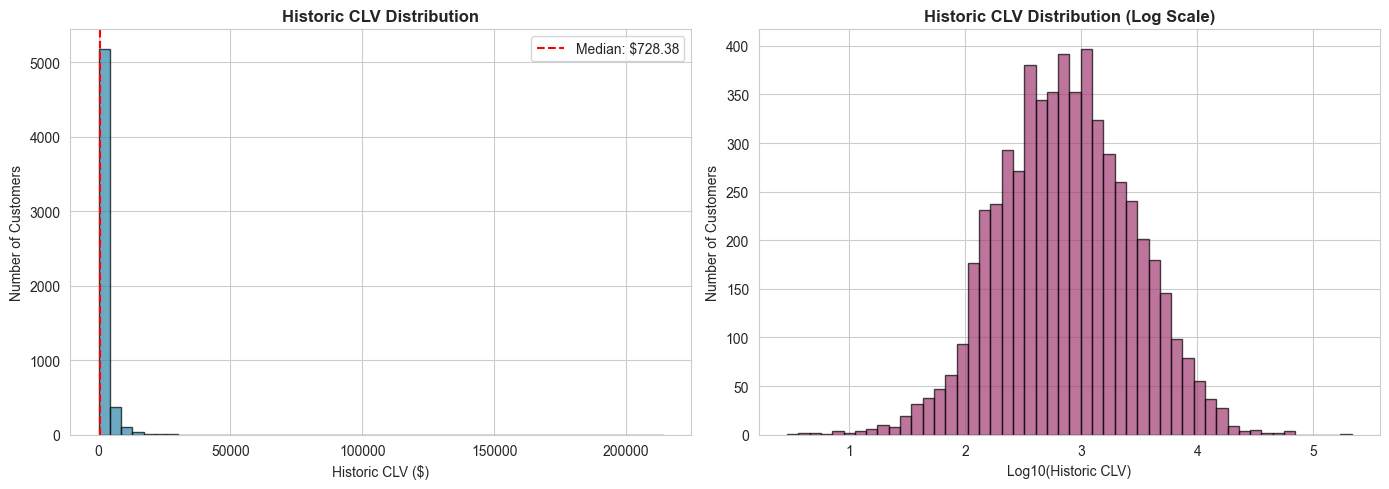

In [11]:
print("\n\n" + "="*80)
print("💰 HISTORIC CUSTOMER LIFETIME VALUE (CLV)")
print("="*80)

# Calculate historic CLV
historic_clv = calculate_historic_clv(df)

print(f"\nHistoric CLV calculated for {len(historic_clv):,} customers")
print("\n📊 Historic CLV Statistics:")
print(historic_clv['historic_clv'].describe())

# Top customers by CLV
print("\n🏆 Top 10 Customers by Historic CLV:")
top_customers = historic_clv.nlargest(10, 'historic_clv')
print(top_customers[['customer_id', 'historic_clv', 'total_orders', 
                      'avg_order_value', 'customer_lifespan_days']].to_string(index=False))

# CLV distribution plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(historic_clv['historic_clv'], bins=50, color='#2E86AB', alpha=0.7, edgecolor='black')
axes[0].set_title('Historic CLV Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Historic CLV ($)')
axes[0].set_ylabel('Number of Customers')
axes[0].axvline(historic_clv['historic_clv'].median(), color='red', linestyle='--',
                label=f"Median: ${historic_clv['historic_clv'].median():.2f}")
axes[0].legend()

axes[1].hist(np.log10(historic_clv['historic_clv'] + 1), bins=50, 
             color='#A23B72', alpha=0.7, edgecolor='black')
axes[1].set_title('Historic CLV Distribution (Log Scale)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Log10(Historic CLV)')
axes[1].set_ylabel('Number of Customers')

plt.tight_layout()
plt.show()

## 9. PREPARE DATA FOR PREDICTIVE CLV

In [12]:
print("\n\n" + "="*80)
print("🔮 PREDICTIVE CLV MODELING")
print("="*80)

# Prepare data for CLV modeling
customer_clv_data = prepare_clv_data(df, prediction_period_months=12)

print(f"\nData prepared for {len(customer_clv_data):,} customers (with repeat purchases)")
print("\n📊 Customer Metrics Summary:")
print(customer_clv_data[['frequency', 'recency_days', 'T_days', 'monetary_value']].describe())




🔮 PREDICTIVE CLV MODELING

Data prepared for 4,113 customers (with repeat purchases)

📊 Customer Metrics Summary:
         frequency  recency_days       T_days  monetary_value
count  4113.000000   4113.000000  4113.000000     4113.000000
mean      6.902747    377.149040   518.840749      286.982317
std      13.485681    229.073338   203.532535      192.367685
min       1.000000      0.000000     3.000000        5.230000
25%       2.000000    165.000000   402.000000      165.206667
50%       3.000000    380.000000   583.000000      249.831667
75%       8.000000    586.000000   686.000000      358.035000
max     373.000000    738.000000   738.000000     2737.161176


## 10. CALCULATE PREDICTIVE CLV


📈 CALCULATING PREDICTIVE CLV (12-Month Forecast)

Predictive CLV calculated for 4,113 customers

📊 Predicted CLV Statistics:
count      4113.000000
mean       1450.840484
std        3571.499607
min           6.315689
25%         287.497761
50%         683.824480
75%        1646.192711
max      146409.320073
Name: predicted_clv, dtype: float64

🏆 Top 10 Customers by Predicted CLV (Next 12 Months):
 customer_id  frequency  monetary_value  predicted_purchases  predicted_clv
       14096         16     2737.161176            57.029703  146409.320073
       14911        373      572.186016           181.951220   97647.123234
       18139          5      610.110000           105.882353   60589.723388
       13089        174      396.264171            85.108696   31631.951380
       14298         74      885.611867            36.643741   30437.605198
       17509          7      764.392500            40.645161   29140.198865
       17841        209      296.819667           102.228261   2845

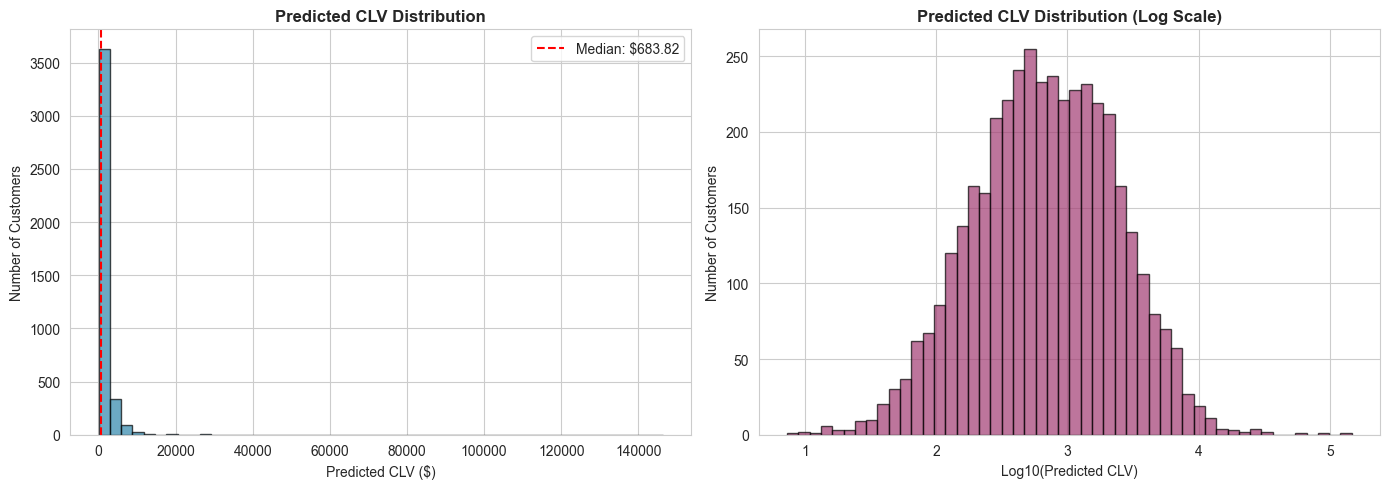

In [13]:
print("\n" + "="*80)
print("📈 CALCULATING PREDICTIVE CLV (12-Month Forecast)")
print("="*80)

# Calculate predictive CLV
clv_predicted = calculate_simple_predictive_clv(customer_clv_data, 
                                                 prediction_months=12, 
                                                 discount_rate=0.01)

print(f"\nPredictive CLV calculated for {len(clv_predicted):,} customers")
print("\n📊 Predicted CLV Statistics:")
print(clv_predicted['predicted_clv'].describe())

# Show top predicted CLV customers
print("\n🏆 Top 10 Customers by Predicted CLV (Next 12 Months):")
top_clv = clv_predicted.nlargest(10, 'predicted_clv')
print(top_clv[['customer_id', 'frequency', 'monetary_value', 'predicted_purchases', 
               'predicted_clv']].to_string(index=False))

# Plot predicted CLV distribution
plot_clv_distribution(clv_predicted)


## 11. CLV SEGMENTATION


💎 CLV VALUE SEGMENTATION

Customers segmented into value tiers

💰 Value Segment Summary:
    value_segment  num_customers  total_predicted_clv  avg_predicted_clv     min_clv       max_clv
       High Value            412         2.793425e+06        6780.157732 3269.264651 146409.320073
Medium-High Value            617         1.412426e+06        2289.183790 1646.192711   3264.930772
     Medium Value           1028         1.127539e+06        1096.827517  683.824480   1645.968707
 Low-Medium Value           1028         4.732187e+05         460.329469  287.497761    683.230936
        Low Value           1028         1.606981e+05         156.321154    6.315689    287.472470


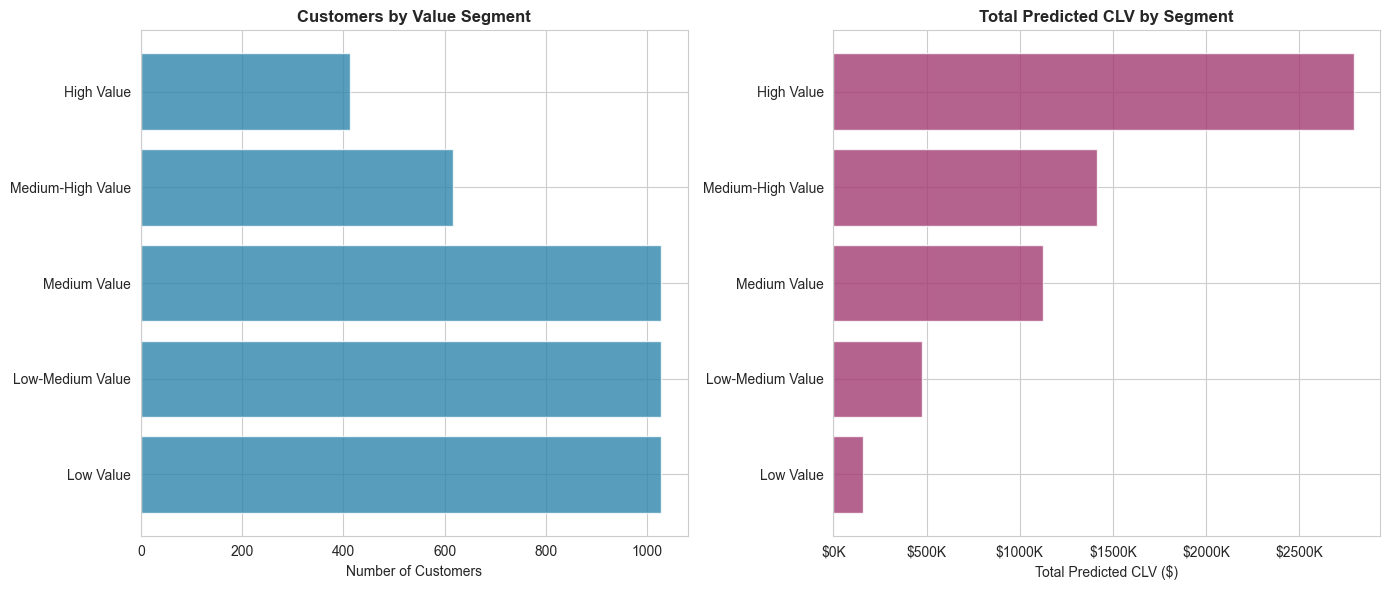

In [15]:
print("\n" + "="*80)
print("💎 CLV VALUE SEGMENTATION")
print("="*80)

# Segment by CLV
clv_segmented = calculate_clv_segments(clv_predicted)

print(f"\nCustomers segmented into value tiers")

# Value segment distribution
value_segment_summary = clv_segmented.groupby('value_segment').agg({
    'customer_id': 'count',
    'predicted_clv': ['sum', 'mean', 'min', 'max']
}).reset_index()

value_segment_summary.columns = ['value_segment', 'num_customers', 
                                  'total_predicted_clv', 'avg_predicted_clv',
                                  'min_clv', 'max_clv']

# Sort by value
segment_order = ['High Value', 'Medium-High Value', 'Medium Value', 
                 'Low-Medium Value', 'Low Value']
value_segment_summary['value_segment'] = pd.Categorical(
    value_segment_summary['value_segment'], 
    categories=segment_order, 
    ordered=True
)
value_segment_summary = value_segment_summary.sort_values('value_segment')

print("\n💰 Value Segment Summary:")
print(value_segment_summary.to_string(index=False))

# Visualize value segments
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Customer count by value segment
axes[0].barh(value_segment_summary['value_segment'], 
             value_segment_summary['num_customers'], 
             color='#2E86AB', alpha=0.8)
axes[0].set_title('Customers by Value Segment', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Number of Customers')
axes[0].invert_yaxis()

# Total CLV by value segment
axes[1].barh(value_segment_summary['value_segment'], 
             value_segment_summary['total_predicted_clv'], 
             color='#A23B72', alpha=0.8)
axes[1].set_title('Total Predicted CLV by Segment', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Total Predicted CLV ($)')
axes[1].xaxis.set_major_formatter(FuncFormatter(lambda x, p: f'${x/1e3:.0f}K'))
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()


## 12. COMBINE RFM AND CLV ANALYSIS



🔄 COMBINING RFM SEGMENTS WITH CLV PREDICTIONS

Combined analysis for 4,113 customers

📊 RFM Segments with CLV Predictions:
            segment  num_customers  historic_revenue  total_predicted_clv  avg_predicted_clv
          Champions           1265       6265490.985         3.733422e+06        2951.322050
Potential Loyalists            612        487434.810         8.513728e+05        1391.132062
    Loyal Customers            675       1268482.686         6.761175e+05        1001.655525
     Need Attention            781        890528.342         3.873943e+05         496.023472
          Promising            347        307811.373         1.923191e+05         554.233657
     About to Sleep            433        345564.890         1.266808e+05         292.565375


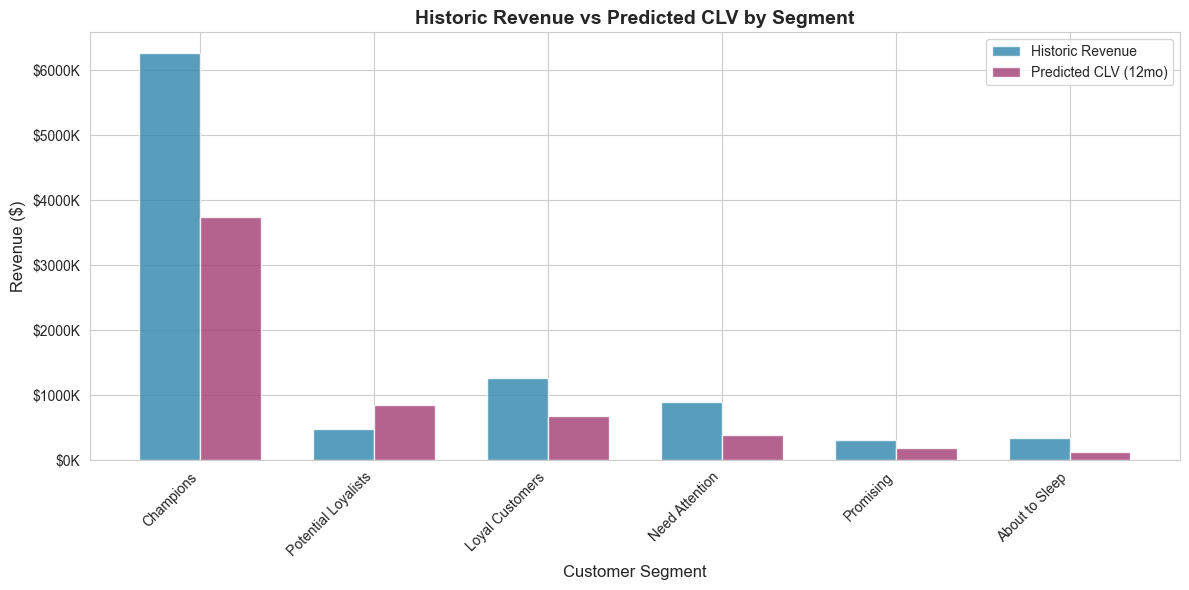


✅ RFM and CLV analysis combined successfully!


In [16]:
print("\n\n" + "="*80)
print("🔄 COMBINING RFM SEGMENTS WITH CLV PREDICTIONS")
print("="*80)

# Merge RFM segments with CLV predictions
rfm_clv_combined = rfm_segmented.merge(
    clv_segmented[['customer_id', 'predicted_clv', 'value_segment']], 
    on='customer_id', 
    how='inner'
)

print(f"\nCombined analysis for {len(rfm_clv_combined):,} customers")

# Analyze RFM segments by predicted CLV
segment_clv_analysis = rfm_clv_combined.groupby('segment').agg({
    'customer_id': 'count',
    'monetary': 'sum',
    'predicted_clv': ['sum', 'mean']
}).reset_index()

segment_clv_analysis.columns = ['segment', 'num_customers', 'historic_revenue', 
                                 'total_predicted_clv', 'avg_predicted_clv']

segment_clv_analysis = segment_clv_analysis.sort_values('total_predicted_clv', ascending=False)

print("\n📊 RFM Segments with CLV Predictions:")
print(segment_clv_analysis.to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(segment_clv_analysis))
width = 0.35

bars1 = ax.bar(x - width/2, segment_clv_analysis['historic_revenue'], 
               width, label='Historic Revenue', color='#2E86AB', alpha=0.8)
bars2 = ax.bar(x + width/2, segment_clv_analysis['total_predicted_clv'], 
               width, label='Predicted CLV (12mo)', color='#A23B72', alpha=0.8)

ax.set_xlabel('Customer Segment', fontsize=12)
ax.set_ylabel('Revenue ($)', fontsize=12)
ax.set_title('Historic Revenue vs Predicted CLV by Segment', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(segment_clv_analysis['segment'], rotation=45, ha='right')
ax.legend()
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'${x/1e3:.0f}K'))

plt.tight_layout()
plt.show()
print("\n✅ RFM and CLV analysis combined successfully!")

## 13. IDENTIFY HIGH-VALUE CUSTOMERS

In [17]:
print("\n\n" + "="*80)
print("🎯 HIGH-VALUE CUSTOMER IDENTIFICATION")
print("="*80)

# Define high-value criteria: Champions OR High CLV
high_value_customers = rfm_clv_combined[
    (rfm_clv_combined['segment'] == 'Champions') | 
    (rfm_clv_combined['value_segment'] == 'High Value')
]

print(f"\nHigh-Value Customers: {len(high_value_customers):,}")
print(f"Percentage of total: {len(high_value_customers)/len(rfm_clv_combined)*100:.1f}%")
print(f"Historic Revenue: ${high_value_customers['monetary'].sum():,.2f}")
print(f"Predicted CLV: ${high_value_customers['predicted_clv'].sum():,.2f}")
print(f"Revenue Contribution: {high_value_customers['monetary'].sum()/rfm_clv_combined['monetary'].sum()*100:.1f}%")

# Show sample high-value customers
print("\n🏆 Sample High-Value Customers:")
print(high_value_customers.nlargest(10, 'predicted_clv')[
    ['customer_id', 'segment', 'value_segment', 'recency', 'frequency', 
     'monetary', 'predicted_clv']
].to_string(index=False))



🎯 HIGH-VALUE CUSTOMER IDENTIFICATION

High-Value Customers: 1,358
Percentage of total: 33.0%
Historic Revenue: $6,628,296.83
Predicted CLV: $4,283,013.25
Revenue Contribution: 69.3%

🏆 Sample High-Value Customers:
 customer_id             segment value_segment  recency  frequency  monetary  predicted_clv
       14096           Champions    High Value        4         17  46531.74  146409.320073
       14911           Champions    High Value        1        374 213997.57   97647.123234
       18139           Champions    High Value       18          6   3660.66   60589.723388
       13089           Champions    High Value        4        175  69346.23   31631.951380
       14298           Champions    High Value        8         75  66420.89   30437.605198
       17509           Champions    High Value       58          8   6115.14   29140.198865
       17841           Champions    High Value        2        210  62332.13   28459.737387
       13521 Potential Loyalists    High Value  

## 14. AT-RISK HIGH-VALUE CUSTOMERS

In [18]:
print("\n\n" + "="*80)
print("⚠️  AT-RISK HIGH-VALUE CUSTOMERS (Urgent Action Needed)")
print("="*80)

# Customers with high historic value but showing signs of churn
at_risk_high_value = rfm_clv_combined[
    (rfm_clv_combined['segment'].isin(['At Risk', 'Cannot Lose Them', 'About to Sleep'])) &
    (rfm_clv_combined['monetary'] > rfm_clv_combined['monetary'].quantile(0.75))
]

print(f"\nAt-Risk High-Value Customers: {len(at_risk_high_value):,}")
print(f"Historic Revenue at Risk: ${at_risk_high_value['monetary'].sum():,.2f}")
print(f"Potential CLV Loss: ${at_risk_high_value['predicted_clv'].sum():,.2f}")

if len(at_risk_high_value) > 0:
    print("\n🚨 Top 10 At-Risk High-Value Customers:")
    print(at_risk_high_value.nlargest(10, 'monetary')[
        ['customer_id', 'segment', 'recency', 'frequency', 'monetary', 'predicted_clv']
    ].to_string(index=False))
    
    print("\n💡 Recommended Actions:")
    print("   • Immediate personalized outreach")
    print("   • Exclusive win-back offers")
    print("   • Customer satisfaction surveys")
    print("   • Dedicated account management")



⚠️  AT-RISK HIGH-VALUE CUSTOMERS (Urgent Action Needed)

At-Risk High-Value Customers: 11
Historic Revenue at Risk: $48,409.90
Potential CLV Loss: $22,145.37

🚨 Top 10 At-Risk High-Value Customers:
 customer_id        segment  recency  frequency  monetary  predicted_clv
       17448 About to Sleep      497         46  14556.97    7466.370643
       12835 About to Sleep      428         41   5687.71    2545.689953
       14648 About to Sleep      416         15   4105.74    1777.323915
       15633 About to Sleep      509         12   3383.66    1434.646952
       13214 About to Sleep      418          7   3264.23    1464.684181
       13446 About to Sleep      430         11   3251.89    1505.564537
       17145 About to Sleep      513          4   3014.71    1160.247536
       17032 About to Sleep      548          8   2940.85    1193.491391
       16335 About to Sleep      552          7   2774.00    1092.300347
       14025 About to Sleep      465          8   2731.74    1384.3586

## 15. KEY FINDINGS AND RECOMMENDATIONS

In [19]:
print("\n\n" + "="*80)
print("🎯 KEY FINDINGS & STRATEGIC RECOMMENDATIONS")
print("="*80)

print("\n1️⃣  CUSTOMER SEGMENTATION:")
print(f"   • {rfm_segmented['segment'].nunique()} distinct customer segments identified")
champions_pct = len(rfm_segmented[rfm_segmented['segment']=='Champions'])/len(rfm_segmented)*100
print(f"   • Champions represent {champions_pct:.1f}% of customers")

top_segment_revenue = segment_summary.iloc[0]
print(f"   • Top segment '{top_segment_revenue['segment']}' generates {top_segment_revenue['revenue_pct']:.1f}% of revenue")

print("\n2️⃣  CUSTOMER LIFETIME VALUE:")
print(f"   • Average Historic CLV: ${historic_clv['historic_clv'].mean():,.2f}")
print(f"   • Average Predicted CLV (12mo): ${clv_predicted['predicted_clv'].mean():,.2f}")
print(f"   • Total Predicted Revenue (12mo): ${clv_predicted['predicted_clv'].sum():,.2f}")

high_value_pct = len(clv_segmented[clv_segmented['value_segment']=='High Value'])/len(clv_segmented)*100
print(f"   • High Value customers: {high_value_pct:.1f}% of base")

print("\n3️⃣  REVENUE CONCENTRATION:")
top_20_customers = rfm_clv_combined.nlargest(int(len(rfm_clv_combined)*0.2), 'monetary')
top_20_revenue_pct = top_20_customers['monetary'].sum() / rfm_clv_combined['monetary'].sum() * 100
print(f"   • Top 20% of customers generate {top_20_revenue_pct:.1f}% of revenue")

print("\n4️⃣  RETENTION OPPORTUNITIES:")
need_attention = len(rfm_segmented[rfm_segmented['segment'].isin(['Need Attention', 'About to Sleep', 'At Risk'])])
print(f"   • {need_attention:,} customers need retention efforts")
print(f"   • {len(at_risk_high_value):,} high-value customers at risk of churn")

print("\n5️⃣  STRATEGIC RECOMMENDATIONS:")
print("\n   📈 GROWTH STRATEGIES:")
print("      • Champions: Reward loyalty, create referral programs, VIP treatment")
print("      • Loyal Customers: Upsell/cross-sell opportunities")
print("      • Potential Loyalists: Nurture with engagement campaigns")
print("      • Recent Customers: Welcome programs, first-purchase follow-up")

print("\n   🛡️  RETENTION STRATEGIES:")
print("      • At Risk: Immediate win-back campaigns with incentives")
print("      • Cannot Lose Them: High-touch customer success outreach")
print("      • About to Sleep: Re-engagement emails, special offers")
print("      • Need Attention: Regular communication, value reinforcement")

print("\n   🎯 RESOURCE ALLOCATION:")
print("      • Focus 60% of marketing budget on Champions & Loyal (highest ROI)")
print("      • Allocate 25% to retention of At-Risk segments")
print("      • Invest 15% in converting Potential Loyalists")

print("\n   💰 EXPECTED IMPACT:")
total_predicted = clv_predicted['predicted_clv'].sum()
print(f"      • Predicted 12-month revenue: ${total_predicted:,.2f}")
retention_lift = total_predicted * 0.15  # Assume 15% lift from retention
print(f"      • Potential uplift from retention: ${retention_lift:,.2f}")
print(f"      • ROI target: 5:1 on retention campaigns")

print("\n" + "="*80)
print("✅ RFM & CLV ANALYSIS COMPLETE")
print("="*80)



🎯 KEY FINDINGS & STRATEGIC RECOMMENDATIONS

1️⃣  CUSTOMER SEGMENTATION:
   • 9 distinct customer segments identified
   • Champions represent 22.1% of customers
   • Top segment 'Champions' generates 62.6% of revenue

2️⃣  CUSTOMER LIFETIME VALUE:
   • Average Historic CLV: $1,749.80
   • Average Predicted CLV (12mo): $1,450.84
   • Total Predicted Revenue (12mo): $5,967,306.91
   • High Value customers: 10.0% of base

3️⃣  REVENUE CONCENTRATION:
   • Top 20% of customers generate 62.6% of revenue

4️⃣  RETENTION OPPORTUNITIES:
   • 2,069 customers need retention efforts
   • 11 high-value customers at risk of churn

5️⃣  STRATEGIC RECOMMENDATIONS:

   📈 GROWTH STRATEGIES:
      • Champions: Reward loyalty, create referral programs, VIP treatment
      • Loyal Customers: Upsell/cross-sell opportunities
      • Potential Loyalists: Nurture with engagement campaigns
      • Recent Customers: Welcome programs, first-purchase follow-up

   🛡️  RETENTION STRATEGIES:
      • At Risk: Immed

## 16. EXPORT RESULTS

In [20]:
print("\n" + "="*80)
print("💾 EXPORTING RESULTS")
print("="*80)

# Export RFM segmented data
rfm_clv_combined.to_csv('../reports/rfm_clv_analysis.csv', index=False)
print("✅ Exported: reports/rfm_clv_analysis.csv")

# Export segment summary
segment_summary.to_csv('../reports/segment_summary.csv', index=False)
print("✅ Exported: reports/segment_summary.csv")

# Export high-value customers
high_value_customers.to_csv('../reports/high_value_customers.csv', index=False)
print("✅ Exported: reports/high_value_customers.csv")

# Export at-risk customers
if len(at_risk_high_value) > 0:
    at_risk_high_value.to_csv('../reports/at_risk_high_value_customers.csv', index=False)
    print("✅ Exported: reports/at_risk_high_value_customers.csv")

print("\n" + "="*80)


💾 EXPORTING RESULTS
✅ Exported: reports/rfm_clv_analysis.csv
✅ Exported: reports/segment_summary.csv
✅ Exported: reports/high_value_customers.csv
✅ Exported: reports/at_risk_high_value_customers.csv



## CLEANUP

In [21]:
conn.close()
print("\n🔒 Database connection closed")
print("\n🎉 Analysis complete! Ready for Phase 5: Churn Modeling")


🔒 Database connection closed

🎉 Analysis complete! Ready for Phase 5: Churn Modeling
